# Feature Engineering with some Preliminary Modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error

In [2]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/mergeB_for_modeling.csv")
df.head(n=3)

# Title case the feature for better display and create the visualizer
labels = list(map(lambda s: s.title(), df.columns.tolist()))
df.columns = labels


# New Feature Creation

In [3]:
# Create features by dividing one column by another or subtracting one column from another.

df["Teacher_Ratio1"] = df.Teachers_Fte / df.Enrollment
df["Teacher_Ratio2"] = df.Teachers_Fte / df.All_Cohort_
df["Num_Grades"] = df.Highest_Grade_Offered - df.Lowest_Grade_Offered


In [4]:
df.dtypes


Year                             int64
Stnam                           object
Fipst                            int64
Leaid                            int64
Leanm                           object
Ncessch                          int64
Schnam                          object
All_Cohort_                      int64
School_Name                     object
Zip_Mailing                    float64
Zip_Location                   float64
Latitude                       float64
Urban_Centric_Locale           float64
County_Code                    float64
School_Level                   float64
School_Type                    float64
Lowest_Grade_Offered           float64
Highest_Grade_Offered          float64
Title_I_Status                 float64
Title_I_Eligible               float64
Charter                        float64
Magnet                         float64
Virtual                        float64
Teachers_Fte                   float64
Free_Lunch                     float64
Reduced_Price_Lunch      

# Prepare dataframes and train-test split for modeling

In [5]:
def Make_X_y(df: pd.DataFrame):
    """
    # Subset to features used in modeling. 
    # Tag categoricals to the pandas type categorical. 
    """

    X = df.copy()

    X.drop(
        [
            "Stnam",
            "Leanm",
            "Ncessch",
            "Schnam",
            "School_Name",
            "Zip_Mailing",
            "Leaid",
            "Zip_Location",
            "County_Code",
            "Fipst",
            "Area_Name",
            "Year",
        ],
        inplace=True,
        axis=1,
    )

    y = X.pop("All_Rate_")

    # Tag categoricals so that they can be treated properly by the modeling packages
    categoricals = ['Urban_Centric_Locale', 'School_Level', 'School_Type', 'Title_I_Status', 'Title_I_Eligible',
                    'Charter', 'Magnet', 'Virtual', 'Ungrade_Cedp', 'Rural_Urban_Continuum_Code', 'Urban_Influence_Code', 'Metro_Or_Not']

    # Convert categoricals to the pandas type 'category'
    for col in categoricals:
        X[col] = X[col].astype("category")

    # Create train-test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=42
    )
    return X, y, Xtrain, Xtest, ytrain, ytest


In [6]:
X, y, Xtrain, Xtest, ytrain, ytest = Make_X_y(df)
pd.set_option("display.max_rows", 999)
X.dtypes


All_Cohort_                       int64
Latitude                        float64
Urban_Centric_Locale           category
School_Level                   category
School_Type                    category
Lowest_Grade_Offered            float64
Highest_Grade_Offered           float64
Title_I_Status                 category
Title_I_Eligible               category
Charter                        category
Magnet                         category
Virtual                        category
Teachers_Fte                    float64
Free_Lunch                      float64
Reduced_Price_Lunch             float64
Free_Or_Reduced_Price_Lunch     float64
Enrollment                      float64
Ungrade_Cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
Rural_Urban_Continuum_Code     category
Urban_Influence_Code           category
Metro_Or_Not                   category
Civilian_Labor_Force            float64
Unemployment_Rate               float64


In [7]:
Xtrain.head(n=2)


,All_Cohort_,Latitude,Urban_Centric_Locale,School_Level,School_Type,Lowest_Grade_Offered,Highest_Grade_Offered,Title_I_Status,Title_I_Eligible,Charter,Magnet,Virtual,Teachers_Fte,Free_Lunch,Reduced_Price_Lunch,Free_Or_Reduced_Price_Lunch,Enrollment,Ungrade_Cedp,Math_Pct_Part,Rla_Pct_Part,Rural_Urban_Continuum_Code,Urban_Influence_Code,Metro_Or_Not,Civilian_Labor_Force,Unemployment_Rate,Teacher_Ratio1,Teacher_Ratio2,Num_Grades
28263,18,39.80761,43.0,3.0,1.0,7.0,12.0,1.0,1.0,0.0,0.0,0.0,18.000000,58.0,21.0,79.0,146.0,0.0,90.0,90.0,9.0,12.0,0.0,1518.0,2.4,0.123288,1.00000,5.0
12172,40,35.35770,42.0,3.0,1.0,7.0,12.0,5.0,1.0,0.0,0.0,0.0,32.709999,130.0,49.0,179.0,277.0,0.0,97.5,95.0,4.0,5.0,0.0,35304.0,7.6,0.118087,0.81775,5.0


# Hyper-parameter tuning of RandomForest models 

In [8]:
# Create and run hyperparameter tuning pipeline
from sklearn.model_selection import GridSearchCV
import warnings
import joblib
import os

warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
param_grid = {
    "rf__n_estimators": [500, 1000],
    "rf__max_features": [55],
    "rf__max_depth": [5, 15, 25, 35, 45, 65, 75, 85, 90],
    "rf__ccp_alpha": [0.0],
    "rf__random_state": [42],
}
pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        ("rf", RandomForestRegressor()),
    ]
)

# Load model from disk instead of running again.
clf = {}
local_model_path = (
    "../../student_outcome_saved_models/model_datasetB_random_forest_gridsearch3.pkl"
)
if os.path.exists(local_model_path):
    clf = joblib.load(local_model_path)
else:
    clf = GridSearchCV(
        pipe,
        param_grid,
        n_jobs=4,
        verbose=3,
        cv=6,
        scoring="r2",
    )
    clf.fit(Xtrain, ytrain)
    joblib.dump(clf, local_model_path)

del clf


## Best parameters from GridSearch
    * First round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 100, 'rf__max_features': 60, 'rf__n_estimators': 500, 'rf__random_state': 42}
    * Second round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 90, 'rf__max_features': 55, 'rf__n_estimators': 500, 'rf__random_state': 42}
    * Third round: {'rf__ccp_alpha': 0.0, 'rf__max_depth': 35, 'rf__max_features': 55, 'rf__n_estimators': 1000
    'rf__random_state': 42}

In [9]:
# clf.best_params_
# residuals_plot(clf.best_estimator_, Xtrain, ytrain, Xtest, ytest)

# Convert To Classification Problem

# Perform Classification with 3 Classes

Bins: [84.5 92. ]


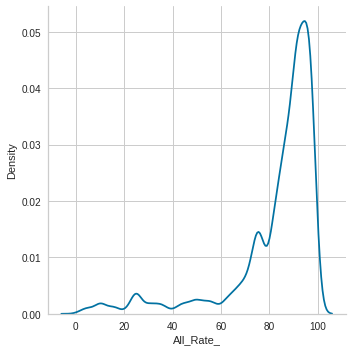

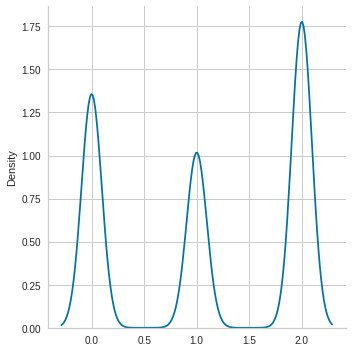

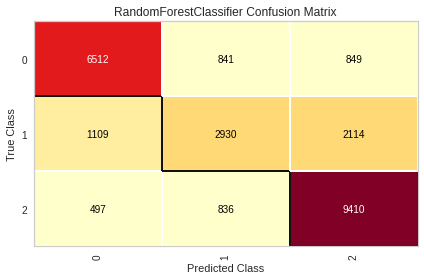

0.7511355486492948


In [10]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix


bins = np.percentile(ytrain, [33, 66])
ytrain_binned = np.digitize(ytrain, bins=bins)
ytest_binned = np.digitize(ytest, bins=bins)
print("Bins:", bins)
sns.displot(ytrain, kind='kde', label="continuous")
sns.displot(ytrain_binned, kind='kde', label="33,66 bins")
plt.show()


pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        (
            "rf",
            RandomForestClassifier(
                n_jobs=4,
                max_features=55,
                n_estimators=1000,
                max_depth=35,
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe, classes=(0, 1, 2))
conf.fit(Xtrain, ytrain_binned)

conf.score(Xtest, ytest_binned)
conf.show()
print(conf.score_)


# Perform classification with 2 classes

Bins: [90.]


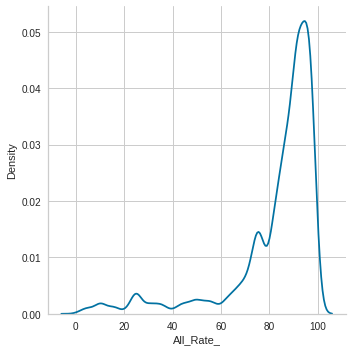

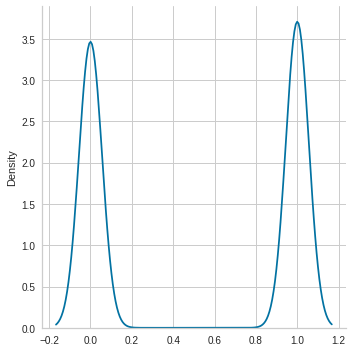

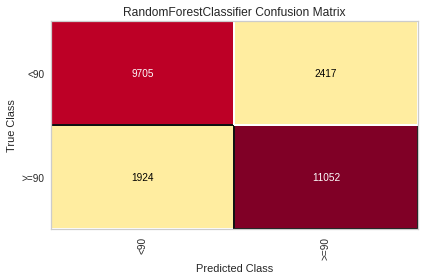

0.8270380109968922


In [11]:
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ConfusionMatrix

bins = np.percentile(ytrain, [50])
ytrain_binned = np.digitize(ytrain, bins=bins)
ytest_binned = np.digitize(ytest, bins=bins)
print("Bins:", bins)
sns.displot(ytrain, kind='kde', label="continuous")
sns.displot(ytrain_binned, kind='kde', label="33,66 bins")
plt.show()

pipe = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        (
            "rf",
            RandomForestClassifier(
                n_jobs=4,
                max_features=55,
                n_estimators=1000,
                max_depth=35,
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe, classes=("<90", ">=90"))
conf.fit(Xtrain, ytrain_binned)

conf.score(Xtest, ytest_binned)
conf.show()
print(conf.score_)


# Test an SVM model on the 2 class problem

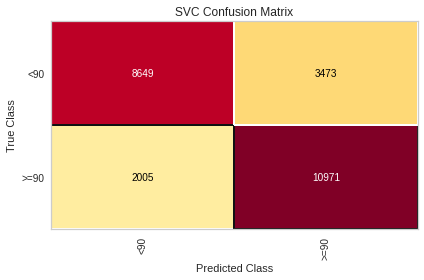

0.7817355964618695


In [12]:
from sklearn.svm import SVC
from yellowbrick.classifier import ConfusionMatrix

scaler = SklearnTransformerWrapper(transformer=StandardScaler(
), variables=Xtrain.select_dtypes(include=np.number).columns.tolist())

pipe = Pipeline(
    steps=[
        ("scaler", scaler),
        ("onehot", OneHotEncoder(drop_last=True, variables=Xtrain.select_dtypes(
            include='category').columns.tolist())),
        (
            "rf",
            SVC(
                C=1,
                kernel="rbf",
                random_state=42,
            ),
        ),
    ]
)
conf = ConfusionMatrix(pipe, classes=("<90", ">=90"))
conf.fit(Xtrain, ytrain_binned)

conf.score(Xtest, ytest_binned)
conf.show()
print(conf.score_)

# SVC C=1, kernel=poly score=0.777
# SVC C=1, kernel=rbf score=0.78


# Feature Importances

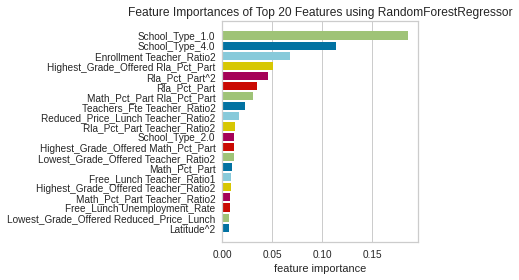

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of Top 20 Features using RandomForestRegressor'}, xlabel='feature importance'>,
                   estimator=RandomForestRegressor(max_depth=10,
                                                   max_features=55,
                                                   n_estimators=350, n_jobs=3),
                   relative=False, topn=20)

In [13]:
from yellowbrick.model_selection import FeatureImportances


def make_poly_onehot_pipe(X):
    scaler = SklearnTransformerWrapper(transformer=StandardScaler(
    ), variables=X.select_dtypes(include=np.number).columns.tolist())
    poly = SklearnTransformerWrapper(transformer=PolynomialFeatures(
        degree=2), variables=X.select_dtypes(include=np.number).columns.tolist())

    pipe = Pipeline(
        steps=[
            ("poly", poly),
            # ("scaler", scaler),
            ("onehot", OneHotEncoder(drop_last=True, variables=X.select_dtypes(
                include='category').columns.tolist())),
        ]
    )
    return pipe


def make_onehot_pipe(X):
    scaler = SklearnTransformerWrapper(transformer=StandardScaler(
    ), variables=X.select_dtypes(include=np.number).columns.tolist())
    poly = SklearnTransformerWrapper(transformer=PolynomialFeatures(
        degree=2), variables=X.select_dtypes(include=np.number).columns.tolist())

    pipe = Pipeline(
        steps=[
            # ("poly",poly),
            # ("scaler", scaler),
            ("onehot", OneHotEncoder(drop_last=True, variables=X.select_dtypes(
                include='category').columns.tolist())),
        ]
    )
    return pipe


def show_feature_importances(Xtrain, ytrain, topn, pipe = make_onehot_pipe(Xtrain)):
    """ Plot feature importances using RandomForestRegressor """
    viz = FeatureImportances(RandomForestRegressor(
        n_estimators=350, max_depth=10, max_features=55, n_jobs=3), topn=topn, relative=False)
    viz.fit(pipe.fit_transform(Xtrain), ytrain)
    viz.show()
    return viz


show_feature_importances(Xtrain, ytrain, 20,make_poly_onehot_pipe(Xtrain))


In [14]:
# Add features discovered via PolynomialFeatures
df['Enrollment Teacher_Ratio2'] = df.Enrollment * df.Teacher_Ratio2
df['Rla_Pct_Part^2'] = df.Rla_Pct_Part * df.Rla_Pct_Part
df['Highest_Grade_Offered Rla_Pct_Part'] = df.Highest_Grade_Offered * df.Rla_Pct_Part
df['Math_Pct_Part Rla_Pct_Part'] = df.Math_Pct_Part * df.Rla_Pct_Part
df['Reduced_Price_Lunch Teacher_Ratio2'] = df.Reduced_Price_Lunch * df.Teacher_Ratio2

X, y, Xtrain, Xtest, ytrain, ytest = Make_X_y(df)
pd.set_option("display.max_rows", 999)
X.dtypes


All_Cohort_                              int64
Latitude                               float64
Urban_Centric_Locale                  category
School_Level                          category
School_Type                           category
Lowest_Grade_Offered                   float64
Highest_Grade_Offered                  float64
Title_I_Status                        category
Title_I_Eligible                      category
Charter                               category
Magnet                                category
Virtual                               category
Teachers_Fte                           float64
Free_Lunch                             float64
Reduced_Price_Lunch                    float64
Free_Or_Reduced_Price_Lunch            float64
Enrollment                             float64
Ungrade_Cedp                          category
Math_Pct_Part                          float64
Rla_Pct_Part                           float64
Rural_Urban_Continuum_Code            category
Urban_Influen

# Recursive Feature Elimination

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import KFold
import joblib
import os
from yellowbrick.model_selection import rfecv
#
# Data points below without the polynomial terms
# recursive_feature_elimination10 - randomforestregressor with whole X_transformed and a select few poly features
#                                   cv 6, max depth 5, 59 features, 276 min
pipe = make_onehot_pipe(X)

cv = KFold(6)

print("Shape of X", X.shape)
X_transformed = pipe.fit_transform(X, y)
print("Shape opf X transformed", X_transformed.shape)

# Load visualizer from disk instead of running again.
visualizer = {}
local_file = (
    "../../student_outcome_saved_models/recursive_feature_elimination10.pkl"
)
if os.path.exists(local_file):
    visualizer = joblib.load(local_file)
else:
    visualizer = rfecv(RandomForestRegressor(n_estimators=50, max_features=0.5,
                       max_depth=5, random_state=42), step=2, X=X_transformed, y=y, cv=cv, scoring='r2')
    joblib.dump(visualizer, local_file)

print(type(visualizer))

Shape of X (83658, 33)
Shape opf X transformed (83658, 69)
<class 'yellowbrick.model_selection.rfecv.RFECV'>


In [16]:
cols = X_transformed.columns.tolist()
cols = pd.Series(cols)
top_feats_mask = (visualizer.ranking_ == 1)
print("num top feats:", sum(top_feats_mask))
top_features = cols.loc[top_feats_mask]

features_to_drop = set(cols) - set(top_features.to_numpy())
features_to_drop

num top feats: 59


{'Metro_Or_Not_0.0',
 'Rural_Urban_Continuum_Code_5.0',
 'Rural_Urban_Continuum_Code_7.0',
 'Title_I_Status_2.0',
 'Urban_Centric_Locale_22.0',
 'Urban_Centric_Locale_32.0',
 'Urban_Influence_Code_3.0',
 'Urban_Influence_Code_4.0',
 'Urban_Influence_Code_6.0',
 'Urban_Influence_Code_9.0'}

## Conclusions
    * The recursive elimination curve produces 59 top features (with categories one-hotted)
    * The first 20 features gives us the majority of the benefit
    * metro_or_not can be dropped. A few categories could be lumped together
    * We will save out 2 dataframes, one with identifier columns and the top 20 features ("mergeB_minimal_features"),
    * and one with all the features except for metro_or_not ("mergeB_final_features")

# Why to remove unhelpful features
    * Reduces modeling time
    * Improves interpretability
    * It is not really required in our case due to the size of the data

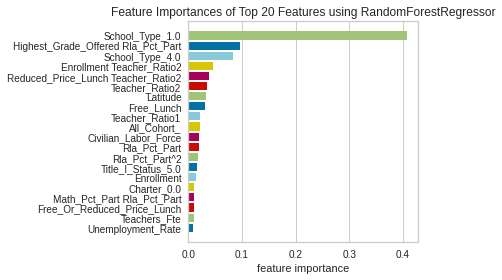

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of Top 20 Features using RandomForestRegressor'}, xlabel='feature importance'>,
                   estimator=RandomForestRegressor(max_depth=10,
                                                   max_features=55,
                                                   n_estimators=350, n_jobs=3),
                   relative=False, topn=20)

In [17]:
show_feature_importances(X,y,topn=20,pipe=make_onehot_pipe(X))

# Save out the dataframe

In [18]:
# Running Feature Importance with two slightly different depths gave us a 21st feature, Charter_0.0 so we added that in too.
top_21_features = ["School_Type_1.0","Highest_Grade_Offered Rla_Pct_Part","Enrollment Teacher_Ratio2", "School_Type_4.0","Teacher_Ratio2","Reduced_Price_Lunch Teacher_Ratio2", "Latitude", "Free_Lunch", "Teacher_Ratio1", "Civilian_Labor_Force", "All_Cohort_", "Enrollment", "Unemployment_Rate", "Teachers_Fte", "Free_Or_Reduced_Price_Lunch", "Rla_Pct_Part", "Rla_Pct_Part^2","Reduced_Price_Lunch", "Math_Pct_Part Rla_Pct_Part", "Title_I_Status_5.0", "Charter_0.0"]
pipe = make_onehot_pipe(X)
X_transformed = pipe.fit_transform(X)
X_transformed = X_transformed[top_21_features]
# Add in identifiers for understanding
X_transformed["All_Rate_"] = y
X_transformed["Ncessch"] = df.Ncessch
X_transformed["Year"] = df.Year
X_transformed["Schnam"] = df.Schnam
X_transformed["Stnam"] = df.Stnam
X_transformed["Fipst"] = df.Fipst
df_minimal = X_transformed
df_minimal.to_csv("../data/mergeB_minimal_features.csv", index=False)
df.drop(["Metro_Or_Not"],axis=1,inplace=True)
df.to_csv("../data/mergeB_final_features.csv", index=False)

# Feature Visualization 

In [19]:
df_minimal

,School_Type_1.0,Highest_Grade_Offered Rla_Pct_Part,Enrollment Teacher_Ratio2,School_Type_4.0,Teacher_Ratio2,Reduced_Price_Lunch Teacher_Ratio2,Latitude,Free_Lunch,Teacher_Ratio1,Civilian_Labor_Force,All_Cohort_,Enrollment,Unemployment_Rate,Teachers_Fte,Free_Or_Reduced_Price_Lunch,Rla_Pct_Part,Rla_Pct_Part^2,Reduced_Price_Lunch,Math_Pct_Part Rla_Pct_Part,Title_I_Status_5.0,Charter_0.0,All_Rate_,Ncessch,Year,Schnam,Stnam,Fipst
0,1,1170.0,221.627990,0,0.438000,12.263999,60.802584,210.0,0.064921,7193.0,75,506.0,15.6,32.849998,238.0,97.5,9506.25,28.0,9506.25,1,1,52.0,20000100208,2012,Bethel Regional High School,ALASKA,2
1,0,1080.0,8.714286,1,0.142857,0.000000,60.795960,58.0,0.065574,7193.0,28,61.0,15.6,4.000000,58.0,90.0,8100.00,0.0,8100.00,1,1,10.0,20000100318,2012,Bethel Alternative Boarding School,ALASKA,2
2,1,1170.0,126.126761,0,0.316901,11.091549,57.051810,224.0,0.056533,4627.0,71,398.0,5.7,22.500000,259.0,97.5,9506.25,35.0,9506.25,1,1,97.5,20000600558,2012,Mt. Edgecumbe High School,ALASKA,2
3,1,1080.0,34.065882,0,0.448235,1.792941,58.733307,29.0,0.100263,479.0,17,76.0,10.0,7.620000,33.0,90.0,8100.00,4.0,8100.00,0,1,90.0,20003000020,2012,Bristol Bay Middle/High School,ALASKA,2
4,1,1140.0,70.616664,0,0.464583,8.362500,60.540506,57.0,0.073355,4877.0,24,152.0,9.8,11.150000,75.0,95.0,9025.00,18.0,9025.00,0,1,90.0,20006000029,2012,Cordova Jr/Sr High School,ALASKA,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83653,1,1194.0,186.612898,0,0.248817,18.910107,41.501919,110.0,0.061707,21383.0,186,750.0,4.2,46.279999,186.0,99.5,9900.25,76.0,9900.25,0,1,97.5,560576200324,2018,Green River High School,WYOMING,56
83654,1,1194.0,229.781597,0,0.319141,15.637914,43.457147,83.0,0.072250,15467.0,163,720.0,3.0,52.020000,132.0,99.5,9900.25,49.0,9900.25,0,1,97.5,560583000335,2018,Jackson Hole High School,WYOMING,56
83655,1,1080.0,15.925000,0,0.325000,1.300000,43.460060,16.0,0.132653,15467.0,20,49.0,3.0,6.500000,20.0,90.0,8100.00,4.0,8100.00,0,1,90.0,560583000512,2018,Summit Innovations School,WYOMING,56
83656,1,1140.0,35.280001,0,0.504000,5.544000,44.097024,18.0,0.180000,3786.0,25,70.0,3.5,12.600000,29.0,95.0,9025.00,11.0,9025.00,0,1,69.5,560609000401,2018,Upton High School,WYOMING,56


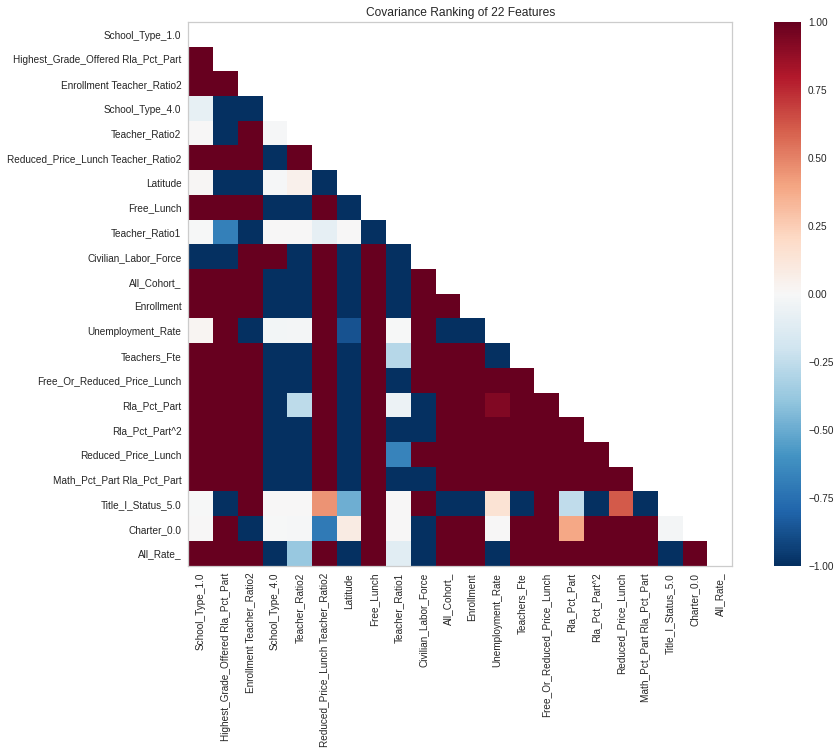

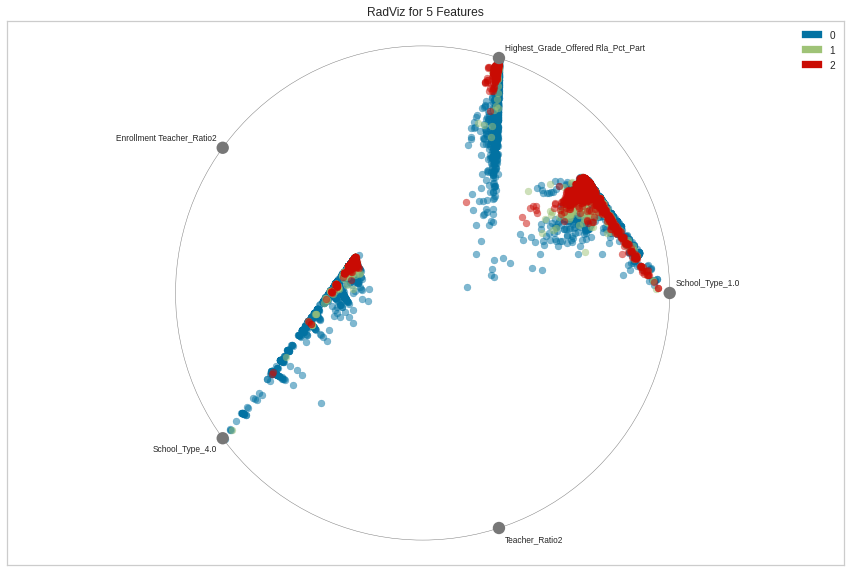

<AxesSubplot:title={'center':'RadViz for 5 Features'}>

In [20]:
# Rad viz using equal sized blocked
# Rad viz using percentile


from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz
from yellowbrick.features import ParallelCoordinates


visualizer = Rank2D(algorithm='covariance', features=(df_minimal[top_21_features + ['All_Rate_']].columns.tolist()) , size=(1080, 720))
visualizer.fit(df_minimal[top_21_features + ['All_Rate_']], y=None)
visualizer.transform(df_minimal[top_21_features + ['All_Rate_']])
visualizer.show()

# Split y into 3 bins
# Rad viz using top 5 features
bins = np.percentile(y, [33, 66])
y_binned = np.digitize(y,bins=bins)
features = top_21_features[0:5]
visualizer = RadViz(classes=None, alpha=0.5,
                  features=features, size=(1080, 720), fontsize=40)
visualizer.fit(df_minimal[features], y_binned)
visualizer.transform(df_minimal[features])
visualizer.show(fontsize=20)
